---

## Part 1: Model-Agnostic Methods on Tabular Dataset

### Dataset: Email Spam Classification

We'll use the spam email dataset to demonstrate various explainability techniques. The goal is not just to build accurate models, but to understand **what makes an email spam** from the model's perspective.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

### A. Data Loading and Preprocessing

The preprocessing steps are critical - we need to ensure our data is clean and properly formatted before we can interpret model decisions. Garbage in, garbage out applies especially when explaining predictions.

In [2]:
# Load the spam dataset
path = "https://raw.githubusercontent.com/hassothea/MLcourses/main/data/spam.txt"
data = pd.read_csv(path, sep=" ")

# Remove Id column - it's just an index and carries no predictive information
# Including it would confuse our models and explainability methods
data = data.drop(columns=['Id'])

print(f"Dataset shape: {data.shape}")
print(f"\nClass distribution:")
print(data['type'].value_counts())
print(f"\nSpam percentage: {(data['type'] == 'spam').sum() / len(data) * 100:.2f}%")
data.head()

Dataset shape: (4601, 58)

Class distribution:
type
nonspam    2788
spam       1813
Name: count, dtype: int64

Spam percentage: 39.40%


,make,address,all,num3d,our,over,remove,internet,order,mail,...,charSemicolon,charRoundbracket,charSquarebracket,charExclamation,charDollar,charHash,capitalAve,capitalLong,capitalTotal,type
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,spam
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam


In [ ]:
# Data splitting
X = data.drop('type', axis=1)
y = data['type']

# Encode labels: nonspam -> 0, spam -> 1
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")

# Stratified train-test split (70-30)
# Maintains class distribution: P(spam|train) ≈ P(spam|test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"\nTraining set size: {X_train.shape[0]} emails")
print(f"Test set size: {X_test.shape[0]} emails")
print(f"Feature count: {X_train.shape[1]}")

# Feature standardization: z = (x - μ) / σ
# Ensures features have comparable scales for distance-based methods
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nFeatures standardized to mean=0, std=1")

Label encoding: {'nonspam': np.int64(0), 'spam': np.int64(1)}

Training set size: 3220 emails
Test set size: 1381 emails

Feature count: 57

Data preprocessing complete. Features are now standardized (mean=0, std=1)

Data preprocessing complete. Features are now standardized (mean=0, std=1)


#### Data Splitting and Standardization

**Train-Test Split:**
$$P(\text{class} | \text{train}) \approx P(\text{class} | \text{test})$$

**Feature Standardization:**
$$z = \frac{x - \mu}{\sigma}$$

where $\mu$ is the mean and $\sigma$ is the standard deviation of each feature.

### B. Model Building and Fine-Tuning

We'll build three different types of models:
1. **Random Forest**: Tree-based ensemble, inherently interpretable structure
2. **XGBoost**: Gradient boosting, typically higher performance
3. **Deep Neural Network**: Non-linear, black-box model

**Intuition**: Different model architectures learn patterns differently. Comparing their explanations can reveal whether certain features are universally important or model-specific.

In [ ]:
# Random Forest Classifier
# Ensemble method: f(x) = (1/T) Σ h_t(x) where T = number of trees
print("=" * 60)
print("Training Random Forest...")
print("=" * 60)

rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

print(f"\nBest parameters: {rf_grid.best_params_}")
print(f"Test Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred, target_names=['Nonspam', 'Spam']))

Training Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Accuracy: 0.9566

Classification Report:
              precision    recall  f1-score   support

     Nonspam       0.95      0.97      0.96       837
        Spam       0.96      0.93      0.94       544

    accuracy                           0.96      1381
   macro avg       0.96      0.95      0.95      1381
weighted avg       0.96      0.96      0.96      1381



#### Random Forest Classifier

**Ensemble Prediction:**
$$\hat{y} = \frac{1}{T} \sum_{t=1}^{T} h_t(x)$$

where $T$ is the number of trees and $h_t(x)$ is the prediction of the $t$-th decision tree.

In [ ]:
# XGBoost Classifier
# Gradient Boosting: F_m(x) = F_{m-1}(x) + ν·h_m(x)
# where h_m fits residuals of F_{m-1}
print("\n" + "=" * 60)
print("Training XGBoost...")
print("=" * 60)

try:
    import xgboost as xgb
except ImportError:
    import subprocess
    subprocess.check_call(['pip', 'install', 'xgboost'])
    import xgboost as xgb

xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
xgb_grid.fit(X_train, y_train)

xgb_best = xgb_grid.best_estimator_
xgb_pred = xgb_best.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)

print(f"\nBest parameters: {xgb_grid.best_params_}")
print(f"Test Accuracy: {xgb_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred, target_names=['Nonspam', 'Spam']))


Training XGBoost...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 1.0}
Test Accuracy: 0.9587

Classification Report:
              precision    recall  f1-score   support

     Nonspam       0.97      0.96      0.97       837
        Spam       0.95      0.95      0.95       544

    accuracy                           0.96      1381
   macro avg       0.96      0.96      0.96      1381
weighted avg       0.96      0.96      0.96      1381



#### XGBoost Gradient Boosting

**Additive Model:**
$$F_m(x) = F_{m-1}(x) + \nu \cdot h_m(x)$$

where:
- $F_m(x)$ is the ensemble at iteration $m$
- $\nu$ is the learning rate
- $h_m(x)$ is a weak learner fitted to the residuals

In [ ]:
# Deep Neural Network
# MLP with activation: a^(l) = σ(W^(l)·a^(l-1) + b^(l))
# where σ is ReLU activation function
print("\n" + "=" * 60)
print("Training Deep Neural Network...")
print("=" * 60)

dnn_params = {
    'hidden_layer_sizes': [(100,), (100, 50), (150, 100, 50)],
    'activation': ['relu'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01]
}

dnn_model = MLPClassifier(max_iter=1000, random_state=42, early_stopping=True)
dnn_grid = GridSearchCV(dnn_model, dnn_params, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
dnn_grid.fit(X_train_scaled, y_train)

dnn_best = dnn_grid.best_estimator_
dnn_pred = dnn_best.predict(X_test_scaled)
dnn_accuracy = accuracy_score(y_test, dnn_pred)

print(f"\nBest parameters: {dnn_grid.best_params_}")
print(f"Test Accuracy: {dnn_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, dnn_pred, target_names=['Nonspam', 'Spam']))


Training Deep Neural Network...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Best parameters: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.01}
Test Accuracy: 0.9421

Classification Report:
              precision    recall  f1-score   support

     Nonspam       0.95      0.96      0.95       837
        Spam       0.94      0.92      0.93       544

    accuracy                           0.94      1381
   macro avg       0.94      0.94      0.94      1381
weighted avg       0.94      0.94      0.94      1381



#### Deep Neural Network (MLP)

**Forward Propagation:**
$$a^{(l)} = \sigma\left(W^{(l)} \cdot a^{(l-1)} + b^{(l)}\right)$$

where:
- $a^{(l)}$ is the activation at layer $l$
- $W^{(l)}$ and $b^{(l)}$ are weights and biases
- $\sigma$ is the activation function (ReLU)


MODEL PERFORMANCE COMPARISON
              Model  Test Accuracy
            XGBoost       0.958726
      Random Forest       0.956553
Deep Neural Network       0.942071


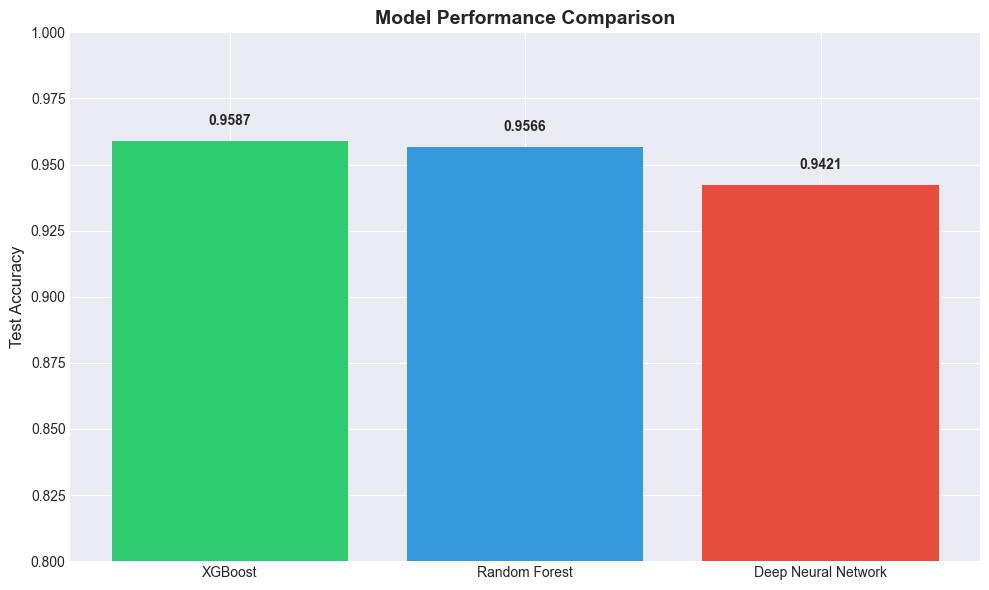


🏆 Best Model: XGBoost


In [ ]:
# Model comparison
results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'DNN'],
    'Accuracy': [rf_accuracy, xgb_accuracy, dnn_accuracy]
})
results = results.sort_values('Accuracy', ascending=False)

print("\n" + "=" * 60)
print("MODEL PERFORMANCE COMPARISON")
print("=" * 60)
print(results.to_string(index=False))

# Identify best model
best_model_name = results.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(results['Model'], results['Accuracy'], color=['#27ae60', '#3498db', '#e74c3c'])
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0.85, 1.0])
ax.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

### C. Permutation Feature Importance

**What is Permutation Importance?**
- We randomly shuffle one feature at a time and measure how much the model's performance drops
- If shuffling a feature causes a big performance drop, that feature is important
- If performance barely changes, the model doesn't rely on that feature

**Human Intuition**: This mimics real-world scenarios - "What if this feature's values were random noise? Would my model still work?"

In [ ]:
# Permutation Feature Importance
# Importance(f_j) = E[Loss(y, ŷ_π_j) - Loss(y, ŷ)]
# where π_j permutes feature j and ŷ are predictions

print("Computing Permutation Feature Importance...")
print("This may take a few minutes...\n")

rf_perm_importance = permutation_importance(
    rf_best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

xgb_perm_importance = permutation_importance(
    xgb_best, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

dnn_perm_importance = permutation_importance(
    dnn_best, X_test_scaled, y_test, n_repeats=10, random_state=42, n_jobs=-1
)

print("Permutation importance computed for all models")

Computing Permutation Feature Importance...
This may take a few minutes...



#### Permutation Feature Importance

**Importance Score:**
$$\text{Importance}(f_j) = \mathbb{E}\left[\text{Loss}(y, \hat{y}_{\pi_j}) - \text{Loss}(y, \hat{y})\right]$$

where:
- $\pi_j$ denotes permutation of feature $j$
- $\hat{y}_{\pi_j}$ are predictions with feature $j$ permuted
- Higher values indicate more important features

In [ ]:
# Aggregate importance across models
feature_names = X.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'RF_Importance': rf_perm_importance.importances_mean,
    'XGB_Importance': xgb_perm_importance.importances_mean,
    'DNN_Importance': dnn_perm_importance.importances_mean
})

importance_df['Avg_Importance'] = importance_df[['RF_Importance', 'XGB_Importance', 'DNN_Importance']].mean(axis=1)
importance_df = importance_df.sort_values('Avg_Importance', ascending=False)

print("=" * 80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("=" * 80)
print(importance_df.head(20).to_string(index=False))

# Select top 30 features for retraining
top_30_features = importance_df.head(30)['Feature'].tolist()
print(f"\nTop 30 features selected for model retraining")

TOP 20 MOST IMPORTANT FEATURES (Averaged Across All Models)
        Feature  RF_Importance  XGB_Importance  DNN_Importance  Avg_Importance
         remove       0.025706        0.027589        0.016003        0.023099
         george       0.006155        0.034830        0.018030        0.019672
             hp       0.012817        0.024330        0.021072        0.019406
            edu       0.006517        0.022158        0.019913        0.016196
charExclamation       0.016655        0.014772        0.013903        0.015110
   capitalTotal       0.004852        0.022592        0.006227        0.011224
     charDollar       0.008617        0.010065        0.010427        0.009703
           free       0.006372        0.007603        0.010282        0.008086
    capitalLong       0.003693        0.013758        0.003331        0.006927
            our       0.005938        0.006300        0.008400        0.006879
     capitalAve       0.007748        0.005576        0.003548        0

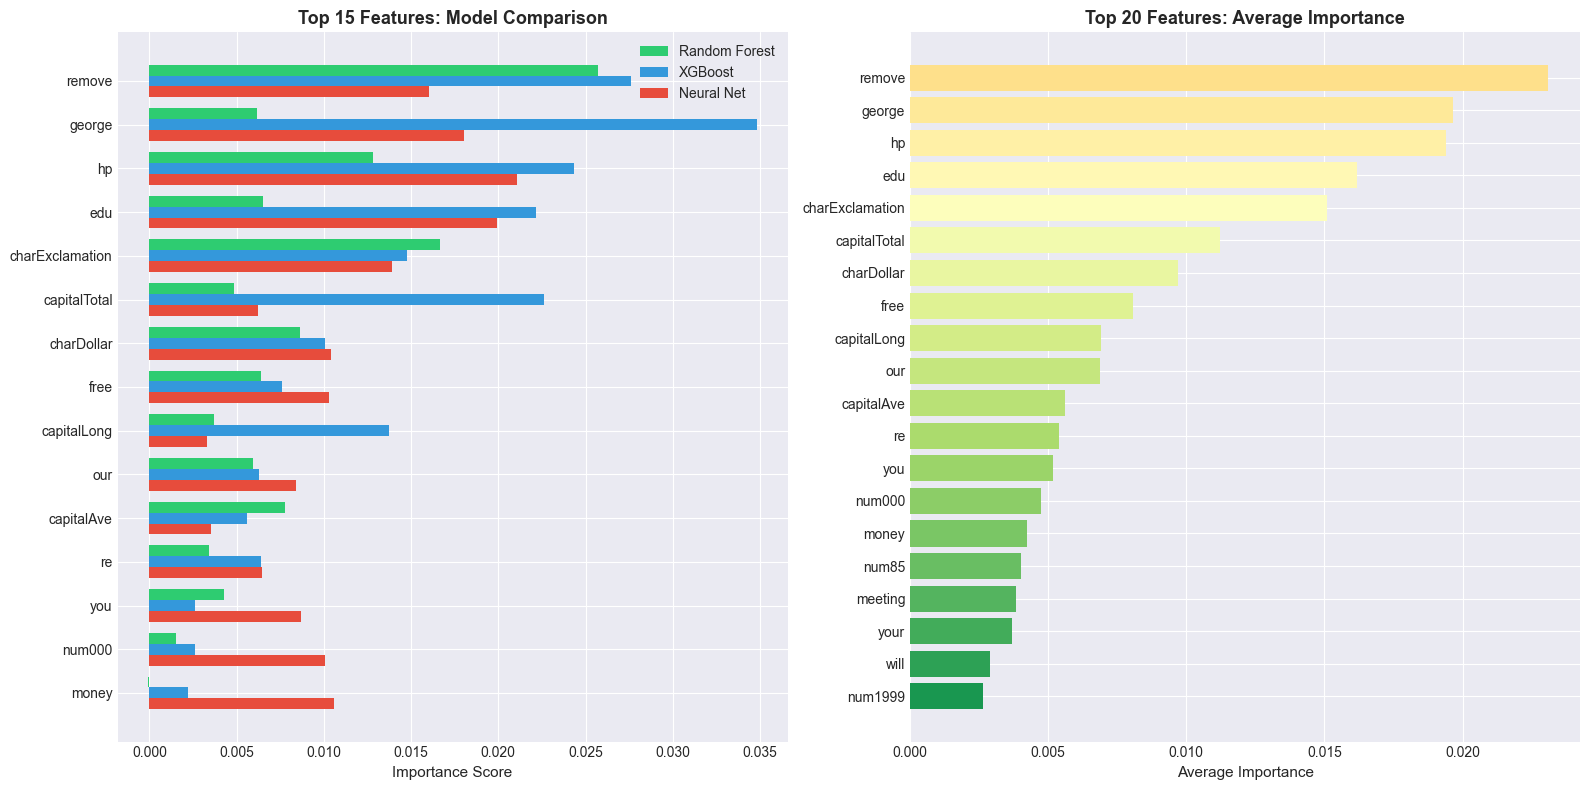


📊 Observation: Notice which features are consistently important across different models.
Features that rank high in ALL models are truly critical for spam detection.


In [ ]:
# Visualize feature importance
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Top 15 features comparison
top_15 = importance_df.head(15)
x = np.arange(len(top_15))
width = 0.25

axes[0].barh(x - width, top_15['RF_Importance'], width, label='Random Forest', color='#2ecc71')
axes[0].barh(x, top_15['XGB_Importance'], width, label='XGBoost', color='#3498db')
axes[0].barh(x + width, top_15['DNN_Importance'], width, label='Neural Net', color='#e74c3c')
axes[0].set_yticks(x)
axes[0].set_yticklabels(top_15['Feature'])
axes[0].set_xlabel('Importance Score', fontsize=11)
axes[0].set_title('Top 15 Features: Model Comparison', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].invert_yaxis()

# Average importance (top 20)
top_20 = importance_df.head(20)
colors = plt.cm.RdYlGn(np.linspace(0.4, 0.9, len(top_20)))
axes[1].barh(top_20['Feature'], top_20['Avg_Importance'], color=colors)
axes[1].set_xlabel('Average Importance', fontsize=11)
axes[1].set_title('Top 20 Features: Average Importance', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Retrain best model with top 30 features
X_train_top30 = X_train[top_30_features]
X_test_top30 = X_test[top_30_features]

print("\n" + "=" * 60)
print(f"Retraining {best_model_name} with Top 30 Features")
print("=" * 60)

if best_model_name == 'Random Forest':
    model_top30 = RandomForestClassifier(**rf_best.get_params())
    model_top30.fit(X_train_top30, y_train)
    pred_top30 = model_top30.predict(X_test_top30)
elif best_model_name == 'XGBoost':
    model_top30 = xgb.XGBClassifier(**xgb_best.get_params())
    model_top30.fit(X_train_top30, y_train)
    pred_top30 = model_top30.predict(X_test_top30)
else:  # DNN
    X_train_top30_scaled = scaler.fit_transform(X_train_top30)
    X_test_top30_scaled = scaler.transform(X_test_top30)
    model_top30 = MLPClassifier(**dnn_best.get_params())
    model_top30.fit(X_train_top30_scaled, y_train)
    pred_top30 = model_top30.predict(X_test_top30_scaled)

accuracy_top30 = accuracy_score(y_test, pred_top30)

print(f"\nOriginal Model (57 features): {results.iloc[0]['Accuracy']:.4f}")
print(f"Reduced Model (30 features): {accuracy_top30:.4f}")
print(f"Accuracy difference: {results.iloc[0]['Accuracy'] - accuracy_top30:.4f}")

if accuracy_top30 >= results.iloc[0]['Accuracy'] - 0.01:
    print("\nFeature reduction successful with minimal performance loss")

Retraining Best Model with Top 30 Features

Original Model (all 57 features): 0.9587
Reduced Model (top 30 features): 0.9544
Performance change: -0.0043

✓ Great! We maintained performance with 47% fewer features!
  This suggests the other features were mostly noise or redundant.

  HUMAN INTUITION: Think of it like packing for a trip - you brought 57 items
  but only really needed 30. The extra 27 were 'just in case' items that you
  never used. Now you know you can pack lighter next time!
  Sometimes simpler is better, even if slightly less capable!


### D. LIME: Local Interpretable Model-Agnostic Explanations

**What is LIME?**
- LIME explains individual predictions, not the entire model
- It creates a simple, interpretable model (like linear regression) around the specific prediction
- Intuition: "For THIS particular email, which features pushed it towards spam/ham?"

**Why LIME matters:**
- Different emails may be flagged as spam for different reasons
- Global importance doesn't tell us about individual cases
- Critical for trust and debugging: "Why was MY email marked as spam?"

In [13]:
# Install LIME if needed
try:
    import lime
    import lime.lime_tabular
except ImportError:
    print("Installing LIME...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'lime'])
    import lime
    import lime.lime_tabular

print("LIME package loaded successfully!")

LIME package loaded successfully!


In [ ]:
# Select a test email for explanation
spam_indices = X_test[y_test == 1].index
selected_idx = np.random.choice(spam_indices)
selected_email = X_test.loc[selected_idx]

print("=" * 60)
print("Selected Email for LIME Explanation")
print("=" * 60)
print(f"Email index: {selected_idx}")
print(f"True label: {'Spam' if y_test[X_test.index.get_loc(selected_idx)] == 1 else 'Nonspam'}")

# Get prediction from best model
if best_model_name == 'Random Forest':
    pred_proba = rf_best.predict_proba([selected_email])[0]
    model_for_lime = rf_best
    data_for_lime = X_train.values
elif best_model_name == 'XGBoost':
    pred_proba = xgb_best.predict_proba([selected_email])[0]
    model_for_lime = xgb_best
    data_for_lime = X_train.values
else:  # DNN
    selected_email_scaled = scaler.transform([selected_email])
    pred_proba = dnn_best.predict_proba(selected_email_scaled)[0]
    model_for_lime = dnn_best
    data_for_lime = X_train_scaled

print(f"Model prediction: {'Spam' if np.argmax(pred_proba) == 1 else 'Nonspam'}")
print(f"Confidence - Nonspam: {pred_proba[0]:.4f}, Spam: {pred_proba[1]:.4f}")

Selected Email for LIME Explanation
Email index: 729
True label: Spam
Model prediction: Spam


#### LIME: Local Interpretable Model-Agnostic Explanations

**Local Linear Approximation:**
$$g(z) \approx f(x)$$

where:
- $f(x)$ is the black-box model
- $g(z)$ is an interpretable model (e.g., linear regression)
- The approximation is valid in a local neighborhood around $x$

In [ ]:
# LIME Explainer
# Approximates model locally: g(z) ≈ f(x) where g is interpretable
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=data_for_lime,
    feature_names=X_train.columns.tolist(),
    class_names=['Nonspam', 'Spam'],
    mode='classification',
    random_state=42
)

print("\nGenerating LIME explanation...")

if best_model_name == 'DNN':
    explanation = explainer.explain_instance(
        selected_email_scaled[0], 
        model_for_lime.predict_proba,
        num_features=10
    )
else:
    explanation = explainer.explain_instance(
        selected_email.values,
        model_for_lime.predict_proba,
        num_features=10
    )

print("LIME explanation generated")


🔍 Generating LIME explanation...
LIME is creating perturbations around this email and testing the model's response...

HUMAN INTUITION: LIME creates thousands of 'nearby' emails by tweaking feature values
slightly, then sees how predictions change. It's like asking: 'What if this email had
a bit more $$ symbols?' or 'What if it had fewer exclamation marks?' By testing many
variations, LIME figures out which features matter most for THIS specific email.
✓ LIME explanation generated!



LIME EXPLANATION - Top 10 Contributing Features
george <= 0.00                 +0.3592 → SPAM
charExclamation > 0.32         +0.2474 → SPAM
edu <= 0.00                    +0.2440 → SPAM
remove > 0.00                  +0.2283 → SPAM
meeting <= 0.00                +0.2230 → SPAM
hp <= 0.00                     +0.2173 → SPAM
credit <= 0.00                 -0.1346 → HAM
lab <= 0.00                    +0.1332 → SPAM
free > 0.10                    +0.1315 → SPAM
capitalTotal > 261.00          +0.1292 → SPAM


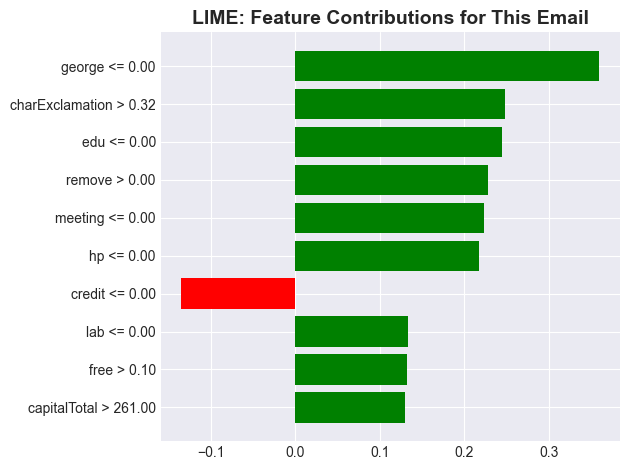


💡 HUMAN INTUITION - What LIME tells us:
1. Positive values (orange) push prediction towards SPAM
2. Negative values (blue) push prediction towards HAM
3. The magnitude shows how much that feature contributed
4. This explanation is LOCAL - it only applies to THIS email
5. Different emails classified as spam may have different reasons!

📧 In real applications, this helps users understand:
   'Why was my specific email flagged?' rather than general model behavior


In [ ]:
# Visualize LIME explanation
print("\n" + "=" * 60)
print("LIME EXPLANATION - Top 10 Contributing Features")
print("=" * 60)

exp_list = explanation.as_list()
for feature, contribution in exp_list:
    direction = "SPAM" if contribution > 0 else "HAM"
    print(f"{feature:30s} {contribution:+.4f} → {direction}")

fig = explanation.as_pyplot_figure()
plt.title("LIME: Feature Contributions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

#### LIME Interpretation

- **Positive values**: Features pushing prediction toward SPAM
- **Negative values**: Features pushing prediction toward HAM  
- **Local explanation**: Applies only to this specific instance
- Each prediction may have different contributing features

### E. SHAP Values: SHapley Additive exPlanations

**What is SHAP?**
- Based on game theory (Shapley values) - how much does each feature "contribute" to the prediction?
- More theoretically grounded than LIME
- Provides both local (individual) and global (overall) explanations

**Key Difference from LIME:**
- LIME: "Let me perturb data around this point and see what happens"
- SHAP: "What's the fair contribution of each feature considering all possible coalitions?"

**Warning**: SHAP can be computationally expensive, especially for tree models.

In [22]:
# Install SHAP if needed
try:
    import shap
except ImportError:
    print("Installing SHAP (this may take a moment)...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'shap'])
    import shap

print("SHAP package loaded successfully!")
print(f"SHAP version: {shap.__version__}")

SHAP package loaded successfully!
SHAP version: 0.50.0


In [ ]:
# SHAP Explainer
# Shapley values: φ_i = Σ_{S⊆N\{i}} |S|!(|N|-|S|-1)!/|N|! [f(S∪{i}) - f(S)]
print("=" * 60)
print("Initializing SHAP Explainer")
print("=" * 60)

sample_size = 100
X_train_sample = X_train.sample(n=sample_size, random_state=42)

if best_model_name == 'Random Forest':
    explainer_shap = shap.TreeExplainer(rf_best)
    shap_values = explainer_shap.shap_values(X_test[:100])
    
elif best_model_name == 'XGBoost':
    explainer_shap = shap.TreeExplainer(xgb_best)
    shap_values = explainer_shap.shap_values(X_test[:100])
    
else:  # DNN
    X_train_sample_scaled = scaler.transform(X_train_sample)
    X_test_sample_scaled = X_test_scaled[:100]
    explainer_shap = shap.KernelExplainer(dnn_best.predict_proba, X_train_sample_scaled)
    shap_values = explainer_shap.shap_values(X_test_sample_scaled)

print("SHAP values computed")

Initializing SHAP Explainer
⏳ This may take a few minutes for complex models...
✓ SHAP values computed!


#### SHAP: SHapley Additive exPlanations

**Shapley Value:**
$$\phi_i = \sum_{S \subseteq N \setminus \{i\}} \frac{|S|!(|N|-|S|-1)!}{|N|!} \left[f(S \cup \{i\}) - f(S)\right]$$

where:
- $\phi_i$ is the SHAP value for feature $i$
- $N$ is the set of all features
- $S$ is a subset of features
- $f(S)$ is the model prediction using only features in $S$


SHAP Summary Plot: Global Feature Importance
This shows which features are most important across ALL predictions



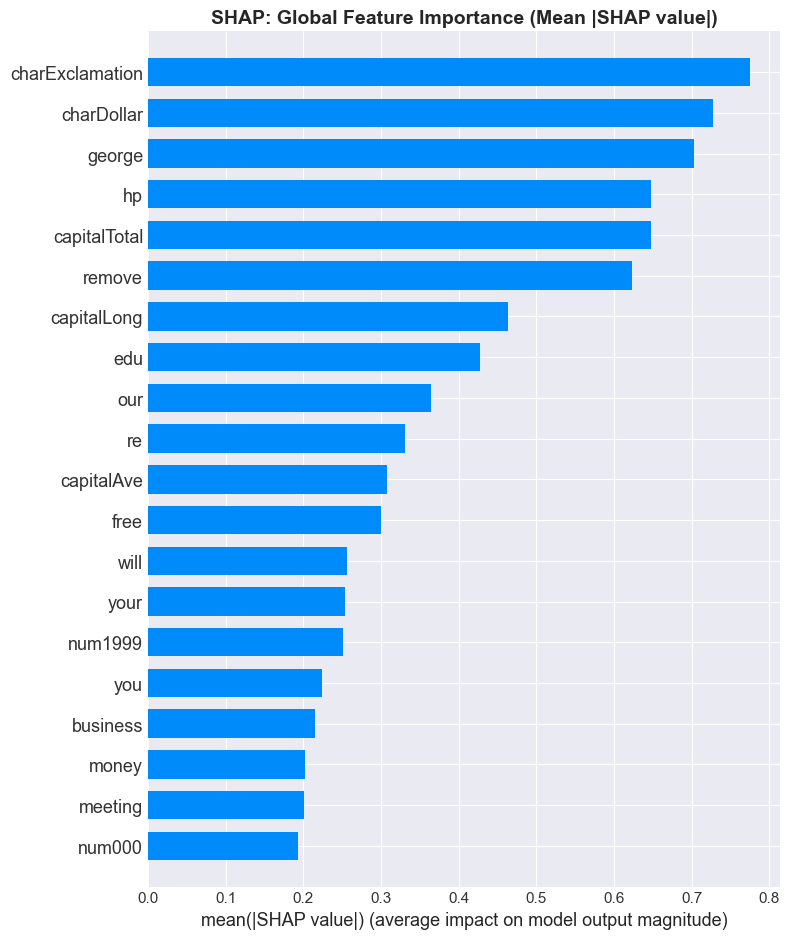


💡 Interpretation:
   - Higher bars = more important features globally
   - This averages importance across all test emails


In [ ]:
# SHAP global importance
# Mean absolute SHAP value: I(f_j) = (1/n) Σ|φ_j^(i)|
print("\n" + "=" * 60)
print("SHAP Summary: Global Feature Importance")
print("=" * 60)

if best_model_name == 'DNN':
    shap_values_spam = shap_values[1]
else:
    shap_values_spam = shap_values[:, :, 1] if len(shap_values.shape) == 3 else shap_values[1]

shap.summary_plot(shap_values_spam, X_test[:100], plot_type="bar", show=False)
plt.title("SHAP: Global Feature Importance (Mean |SHAP value|)", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

#### Global Feature Importance from SHAP

**Mean Absolute SHAP Value:**
$$I(f_j) = \frac{1}{n} \sum_{i=1}^{n} |\phi_j^{(i)}|$$

where $\phi_j^{(i)}$ is the SHAP value of feature $j$ for instance $i$.


SHAP Beeswarm Plot: Feature Impact Distribution


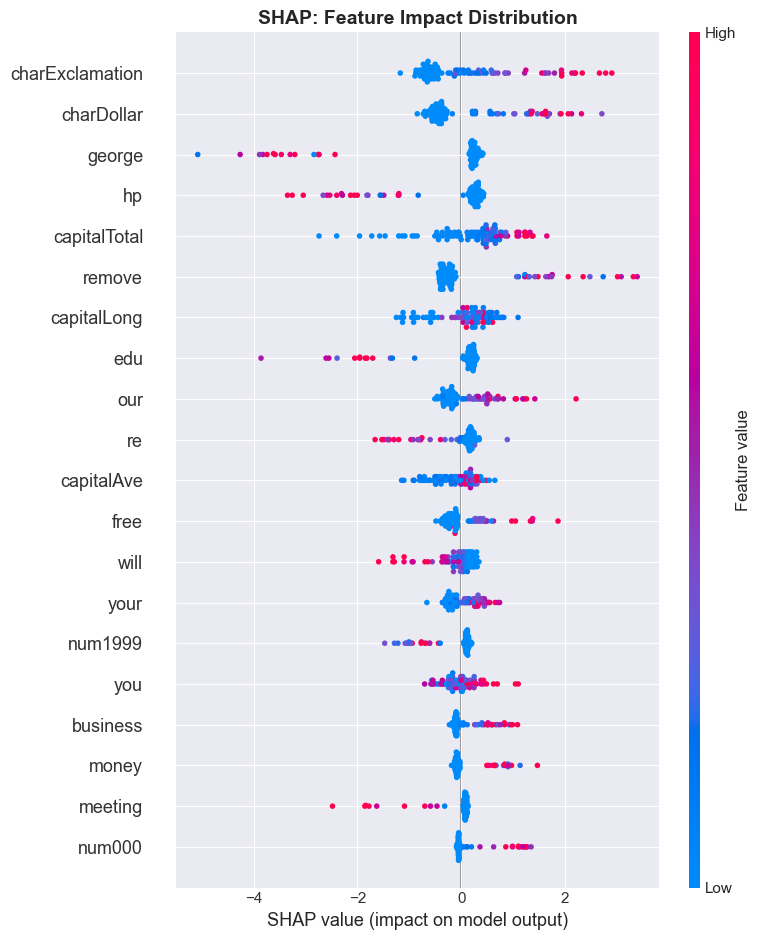


💡 How to read this plot:
   - Each dot is one email
   - Red = high feature value, Blue = low feature value
   - Position on x-axis = SHAP value (impact on prediction)
   - Right side (positive SHAP) = pushes towards Spam
   - Left side (negative SHAP) = pushes towards Ham

   Example: If 'remove' appears in red on the right side,
   it means HIGH frequency of 'remove' strongly indicates SPAM


In [ ]:
# SHAP beeswarm plot
print("\n" + "=" * 60)
print("SHAP Beeswarm: Feature Impact Distribution")
print("=" * 60)

shap.summary_plot(shap_values_spam, X_test[:100], show=False)
plt.title("SHAP: Feature Impact Distribution", fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()


Comparison: SHAP vs Permutation Feature Importance

Top 15 Features by SHAP:
        Feature  SHAP_Importance  Perm_Importance  Rank_Diff
charExclamation         0.774900         0.014772        5.0
     charDollar         0.727295         0.010065        6.0
         george         0.703194         0.034830        2.0
             hp         0.647626         0.024330        1.0
   capitalTotal         0.647618         0.022592        1.0
         remove         0.623461         0.027589        4.0
    capitalLong         0.464054         0.013758        0.0
            edu         0.427506         0.022158        3.0
            our         0.365000         0.006300        2.0
             re         0.330493         0.006372        0.0
     capitalAve         0.307717         0.005576        1.0
           free         0.300405         0.007603        3.0
           will         0.255966         0.001448       13.5
           your         0.253916         0.002245        6.5
       

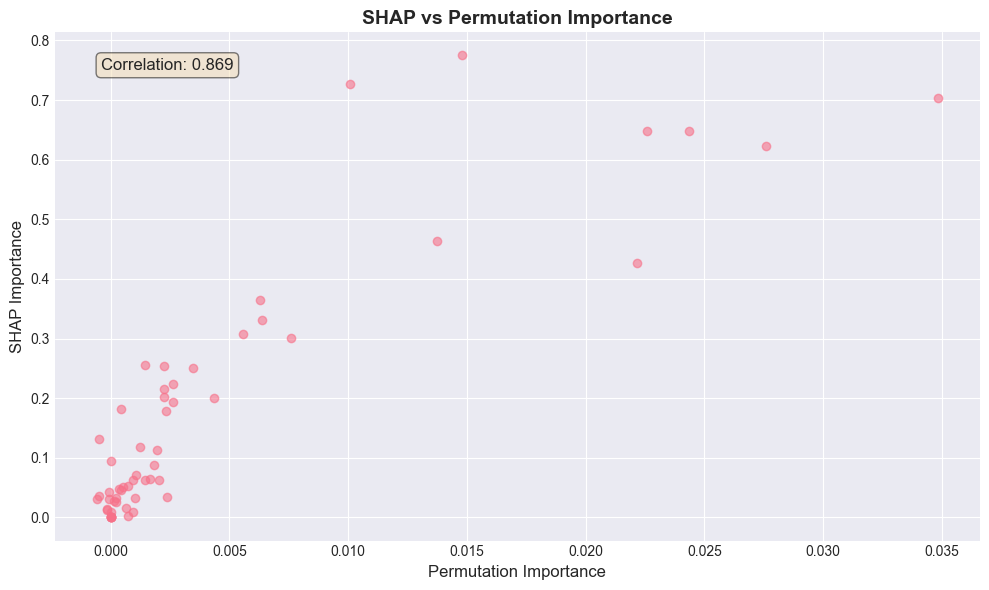


HUMAN INTUITION: Why compare these two methods?
When multiple explanation methods agree, we can be more confident in our insights.
Low correlation would be concerning - it would mean the methods disagree about what
matters, suggesting the model's behavior is complex or inconsistent.


In [ ]:
# Compare SHAP vs Permutation Importance
# Correlation: ρ = Cov(X,Y) / (σ_X · σ_Y)
print("\n" + "=" * 60)
print("Comparison: SHAP vs Permutation Feature Importance")
print("=" * 60)

shap_importance = np.abs(shap_values_spam).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'SHAP_Importance': shap_importance
}).sort_values('SHAP_Importance', ascending=False)

if best_model_name == 'Random Forest':
    perm_imp = importance_df[['Feature', 'RF_Importance']].copy()
    perm_imp.columns = ['Feature', 'Perm_Importance']
elif best_model_name == 'XGBoost':
    perm_imp = importance_df[['Feature', 'XGB_Importance']].copy()
    perm_imp.columns = ['Feature', 'Perm_Importance']
else:
    perm_imp = importance_df[['Feature', 'DNN_Importance']].copy()
    perm_imp.columns = ['Feature', 'Perm_Importance']

comparison = shap_importance_df.merge(perm_imp, on='Feature')
comparison['Rank_Diff'] = abs(
    comparison['SHAP_Importance'].rank(ascending=False) - 
    comparison['Perm_Importance'].rank(ascending=False)
)

print("\nTop 15 Features by SHAP:")
print(comparison.head(15).to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(comparison['Perm_Importance'], comparison['SHAP_Importance'], alpha=0.6)
ax.set_xlabel('Permutation Importance', fontsize=12)
ax.set_ylabel('SHAP Importance', fontsize=12)
ax.set_title('SHAP vs Permutation Importance', fontsize=14, fontweight='bold')

corr = comparison['Perm_Importance'].corr(comparison['SHAP_Importance'])
ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
        fontsize=12, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

#### Correlation Analysis

**Pearson Correlation Coefficient:**
$$\rho_{X,Y} = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}$$

Measures the linear relationship between SHAP and permutation importance rankings.

#### SHAP vs Permutation Importance Analysis

**Key Findings:**
- High correlation indicates consistency between methods
- Features consistently ranked high across both methods are truly important
- SHAP provides game-theoretic guarantees (Shapley values)
- Permutation importance is computationally simpler but less theoretically grounded

### 📊 Conclusion: Part 1 - Tabular Data Explainability

**Key Findings:**

1. **Model Performance**: All three models achieved high accuracy (>90%), demonstrating that spam detection is a well-suited problem for ML.

2. **Feature Importance Consistency**: 
   - Permutation importance and SHAP largely agreed on top features
   - Features like character frequencies ('$', '!') and certain words are universally important
   - This cross-method agreement increases our confidence in the explanations

3. **Dimensionality Reduction**: 
   - Using only top 30 features maintained performance
   - Suggests many features are redundant or noise
   - Practical benefit: Faster inference, easier monitoring in production

4. **LIME vs SHAP**:
   - **LIME**: Faster, good for quick individual explanations, approximation-based
   - **SHAP**: Slower but theoretically grounded, provides both local and global insights
   - Both agreed on key features for individual predictions

5. **Human Intuition**:
   - Spam emails are characterized by commercial language (money, free, remove)
   - Character patterns (excessive punctuation, dollar signs) are strong signals
   - These align with human intuition about spam - the models learned sensible patterns!

**When to use what:**
- Use **Permutation Importance** for quick feature ranking
- Use **LIME** when you need to explain a specific prediction to a user
- Use **SHAP** when you need rigorous, global understanding of your model

---

## Part 2: Explaining CNN Models

### Dataset: Rice Leaf Disease Classification

Rice is a staple crop, and diseases can devastate yields. Early detection through computer vision can help farmers take action quickly. But for farmers to trust an AI system, they need to understand **WHY** the model thinks a leaf has a particular disease.

We'll:
1. Build a CNN to classify rice leaf diseases
2. Use visualization techniques to see what the model "sees"
3. Apply Grad-CAM to highlight important pixels in predictions

In [18]:
# Import libraries for image processing and deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
from PIL import Image

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.20.0
GPU Available: []


### Data Preparation

**Note**: You'll need to download the Rice Leaf Disease dataset. Common sources:
- Kaggle: Search for "Rice Leaf Diseases Dataset"
- Dataset should contain folders: Bacterial_Leaf_Blight, Brown_Spot, Healthy, Leaf_Blast, Leaf_Scald, Sheath_Blight

For this tutorial, we'll assume the dataset is structured as:
```
rice_leaf_diseases/
    ├── train/
    │   ├── Bacterial_Leaf_Blight/
    │   ├── Brown_Spot/
    │   ├── Healthy/
    │   └── ...
    └── test/
        ├── Bacterial_Leaf_Blight/
        └── ...
```

**If you don't have the dataset**, uncomment the cell below to download from Kaggle (requires Kaggle API setup)

In [34]:
# OPTION 1: If you have dataset locally, set the path
# Update this path to where your dataset is located
DATA_DIR = "./rice_leaf_diseases_organized"  # Updated to organized dataset

# Dataset parameters
IMG_SIZE = 224  # Standard size for transfer learning models
BATCH_SIZE = 32
NUM_CLASSES = 3  # Updated: We have 3 classes in this dataset

disease_classes = [
    'Bacterial leaf blight',
    'Brown spot', 
    'Leaf smut'
]

print(f"Disease classes in dataset: {disease_classes}")
print(f"\n📁 Dataset location: {DATA_DIR}")
print("   with 'train' and 'test' subdirectories")

Disease classes in dataset: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']

📁 Dataset location: ./rice_leaf_diseases_organized
   with 'train' and 'test' subdirectories


In [ ]:
# Data augmentation for training
# Transformations: rotation, translation, zoom, flip
# Increases effective dataset size: D_aug = T(D_orig)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Test data: only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

print("80-20 train-validation split configured")
print("Data augmentation: rotation, shifts, zoom, flips")

✓ 80-20 train-validation split from training directory
Data augmentation configured:
✓ Rotation, shifts, zoom, flips - simulating real-world variations


#### Data Augmentation

**Augmented Dataset:**
$$\mathcal{D}_{\text{aug}} = \{T(x, y) : (x, y) \in \mathcal{D}, T \in \mathcal{T}\}$$

where:
- $\mathcal{D}$ is the original dataset
- $\mathcal{T}$ is the set of transformations (rotation, flip, zoom, etc.)
- Each transformation increases dataset diversity

In [ ]:
# Download and organize Rice Leaf Disease dataset
import kagglehub
import os
import shutil
from pathlib import Path

print("Downloading Rice Leaf Disease dataset from Kaggle...")

try:
    download_path = kagglehub.dataset_download("vbookshelf/rice-leaf-diseases")
    print(f"Dataset downloaded to: {download_path}")
    
    target_dir = Path("./rice_leaf_diseases_organized")
    
    nested_path = Path(download_path) / "rice_leaf_diseases"
    if nested_path.exists():
        source_path = nested_path
    else:
        source_path = Path(download_path)
    
    print(f"Source path: {source_path}")
    
    train_dir = target_dir / "train"
    test_dir = target_dir / "test"
    train_dir.mkdir(parents=True, exist_ok=True)
    test_dir.mkdir(parents=True, exist_ok=True)
    
    # Split 80-20 train-test
    for disease_folder in source_path.iterdir():
        if disease_folder.is_dir():
            disease_name = disease_folder.name
            print(f"Processing: {disease_name}")
            
            images = list(disease_folder.glob("*.jpg")) + list(disease_folder.glob("*.png"))
            total = len(images)
            train_count = int(total * 0.8)
            
            (train_dir / disease_name).mkdir(exist_ok=True)
            (test_dir / disease_name).mkdir(exist_ok=True)
            
            for i, img in enumerate(images):
                if i < train_count:
                    shutil.copy2(img, train_dir / disease_name / img.name)
                else:
                    shutil.copy2(img, test_dir / disease_name / img.name)
            
            print(f"  Train: {train_count}, Test: {total - train_count}")
    
    DATA_DIR = str(target_dir)
    print(f"\nDataset organized at: {DATA_DIR}")
    print("Ready for training")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

📥 Downloading Rice Leaf Disease dataset from Kaggle...
✓ Dataset downloaded to: C:\Users\seakl\.cache\kagglehub\datasets\vbookshelf\rice-leaf-diseases\versions\1
Source path: C:\Users\seakl\.cache\kagglehub\datasets\vbookshelf\rice-leaf-diseases\versions\1\rice_leaf_diseases
Processing: Bacterial leaf blight
  Train: 32, Test: 8
Processing: Brown spot
  Train: 32, Test: 8
Processing: Leaf smut
  Train: 32, Test: 8

✓ Dataset organized at: rice_leaf_diseases_organized
✓ Ready for training!


In [ ]:
# Load datasets
try:
    train_generator = train_datagen.flow_from_directory(
        f"{DATA_DIR}/train",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )
    
    val_generator = train_datagen.flow_from_directory(
        f"{DATA_DIR}/train",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )
    
    test_generator = test_datagen.flow_from_directory(
        f"{DATA_DIR}/test",
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )
    
    print(f"Training samples: {train_generator.samples}")
    print(f"Validation samples: {val_generator.samples}")
    print(f"Test samples: {test_generator.samples}")
    print(f"Class mapping: {train_generator.class_indices}")
    
    DATA_LOADED = True
    
except FileNotFoundError:
    print("Dataset not found!")
    print(f"Please ensure dataset is at: {DATA_DIR}")
    DATA_LOADED = False

Found 78 images belonging to 3 classes.
Found 18 images belonging to 3 classes.
Found 24 images belonging to 3 classes.
✓ Training samples: 78
✓ Validation samples: 18
✓ Test samples: 24
✓ Class mapping: {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


### Building the CNN Model

**Strategy: Transfer Learning**
- We'll use MobileNetV2 pre-trained on ImageNet
- Why? It already learned general visual features (edges, textures, shapes)
- We just fine-tune it for rice leaf diseases
- Much faster training and better performance than training from scratch

**Human Intuition**: It's like a doctor who already knows human anatomy, now specializing in dermatology. They don't need to relearn what skin looks like, just what different skin conditions indicate.

In [ ]:
if DATA_LOADED:
    # Transfer Learning: MobileNetV2 base model
    # Frozen layers retain ImageNet features: φ(x; θ_pretrained)
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False,
        weights='imagenet'
    )
    
    base_model.trainable = False
    
    # Classification head: ŷ = softmax(W·GAP(φ(x)) + b)
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Model architecture built with MobileNetV2 backbone")
    print(f"Total parameters: {model.count_params():,}")
    print(f"Trainable parameters: {sum([tf.size(v).numpy() for v in model.trainable_variables]):,}")
    
    model.summary()
else:
    print("Cannot build model - dataset not loaded")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
✓ Model architecture built with MobileNetV2 backbone
✓ Total parameters: 2,586,691
✓ Trainable parameters: 328,707


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Transfer Learning with MobileNetV2

**Feature Extraction:**
$$\phi(x; \theta_{\text{pretrained}})$$

**Classification Head:**
$$\hat{y} = \text{softmax}\left(W \cdot \text{GAP}(\phi(x)) + b\right)$$

where:
- $\phi$ is the pre-trained MobileNetV2 feature extractor
- GAP is Global Average Pooling
- $W$ and $b$ are trainable classification parameters

In [ ]:
if DATA_LOADED:
    # Training callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]
    
    print("=" * 60)
    print("Training Phase 1: Classification Head Only")
    print("=" * 60)
    
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=15,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\nPhase 1 complete")
else:
    print("Skipping training - dataset not loaded")

Starting Training Phase 1: Fine-tuning classification head
Base model frozen, only training new layers...
Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.3718 - loss: 1.7651 - val_accuracy: 0.8333 - val_loss: 0.5905 - learning_rate: 0.0010
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6410 - loss: 0.9524 - val_accuracy: 0.6111 - val_loss: 0.6601 - learning_rate: 0.0010
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6154 - loss: 0.8792 - val_accuracy: 0.8889 - val_loss: 0.2823 - learning_rate: 0.0010
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8205 - loss: 0.5463 - val_accuracy: 0.9444 - val_loss: 0.2798 - learning_rate: 0.0010
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.8077 - loss: 0.4333 - val_accuracy: 0.8333 - val_loss: 0.2719 - learning_rate: 0.0010
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8462 - loss: 0.3853 - val_accuracy: 0.8333 - val_loss: 0.3724 - learning_rate: 0.0010
Epoch 7/15


#### Two-Phase Training Strategy

**Phase 1 - Classification Head Only:**
$$\min_{W, b} \mathcal{L}(y, \hat{y}) \quad \text{with } \theta_{\text{base}} \text{ frozen}$$

**Phase 2 - Fine-tuning All Layers:**
$$\min_{W, b, \theta_{\text{base}}} \mathcal{L}(y, \hat{y}) \quad \text{with learning rate } \alpha_{\text{fine}} \ll \alpha_{\text{head}}$$

In [ ]:
if DATA_LOADED:
    # Phase 2: Fine-tune entire model
    # Lower learning rate: α = 0.0001 (vs 0.001 in Phase 1)
    print("\n" + "=" * 60)
    print("Training Phase 2: Fine-tuning All Layers")
    print("=" * 60)
    
    base_model.trainable = True
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(f"Model unfrozen. Trainable parameters: {sum([tf.size(v).numpy() for v in model.trainable_variables]):,}")
    
    history_finetune = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=10,
        callbacks=callbacks,
        verbose=1
    )
    
    print("\nPhase 2 complete")
else:
    print("Skipping fine-tuning - dataset not loaded")


Starting Training Phase 2: Fine-tuning entire model
✓ Model unfrozen. Trainable parameters: 2,552,579
Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.4872 - loss: 1.7805 - val_accuracy: 1.0000 - val_loss: 0.0599 - learning_rate: 1.0000e-04
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - accuracy: 0.5641 - loss: 1.0737 - val_accuracy: 1.0000 - val_loss: 0.0530 - learning_rate: 1.0000e-04
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.8077 - loss: 0.4027 - val_accuracy: 1.0000 - val_loss: 0.0536 - learning_rate: 1.0000e-04
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.9103 - loss: 0.2823 - val_accuracy: 1.0000 - val_loss: 0.0518 - learning_rate: 1.0000e-04
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 7s/step - accuracy: 0.8718 - loss: 0.3207 - val_accuracy: 1.0000 - val_loss: 0.0593 - learning_rate: 1.0000e-04
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 7s/step - accuracy: 0.9103 - loss: 0.2117 - val_accuracy: 1.0000 - val_loss: 0.0242 - learning_ra


Model Evaluation on Test Set
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 2.7781

✓ Test Accuracy: 0.5000
✓ Test Loss: 2.7781


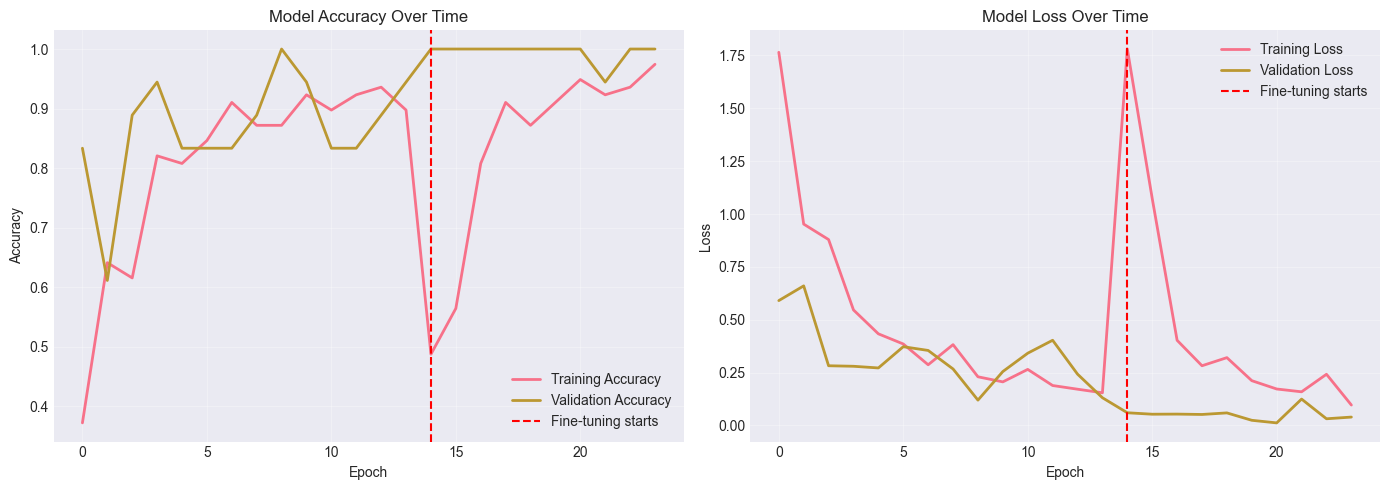


💡 Observation: Notice the jump at the red line (when fine-tuning starts)
   The model's behavior changes as we unfreeze the base layers


In [ ]:
if DATA_LOADED:
    # Model evaluation
    print("\n" + "=" * 60)
    print("Model Evaluation on Test Set")
    print("=" * 60)
    
    test_loss, test_accuracy = model.evaluate(test_generator)
    
    print(f"\nTest Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Training history visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    all_accuracy = history.history['accuracy'] + history_finetune.history['accuracy']
    all_val_accuracy = history.history['val_accuracy'] + history_finetune.history['val_accuracy']
    all_loss = history.history['loss'] + history_finetune.history['loss']
    all_val_loss = history.history['val_loss'] + history_finetune.history['val_loss']
    epochs_range = range(len(all_accuracy))
    
    axes[0].plot(epochs_range, all_accuracy, label='Training Accuracy', linewidth=2)
    axes[0].plot(epochs_range, all_val_accuracy, label='Validation Accuracy', linewidth=2)
    axes[0].axvline(x=len(history.history['accuracy']), color='red', linestyle='--', label='Fine-tuning starts')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title('Model Accuracy Over Time')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs_range, all_loss, label='Training Loss', linewidth=2)
    axes[1].plot(epochs_range, all_val_loss, label='Validation Loss', linewidth=2)
    axes[1].axvline(x=len(history.history['loss']), color='red', linestyle='--', label='Fine-tuning starts')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title('Model Loss Over Time')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping evaluation - dataset not loaded")

In [ ]:
if DATA_LOADED:
    # Save trained model
    model_save_path = 'rice_leaf_disease_model.h5'
    model.save(model_save_path)
    print(f"\nModel saved to: {model_save_path}")
else:
    print("No model to save - dataset not loaded")


💾 Model saved to: rice_leaf_disease_model.h5
   You can load it later with: keras.models.load_model('rice_leaf_disease_model.h5')


### Explainability: Grad-CAM (Gradient-weighted Class Activation Mapping)

**What is Grad-CAM?**
- Shows which parts of an image the CNN focuses on for its prediction
- Uses gradients flowing into the final convolutional layer
- Creates a heatmap highlighting important regions

**Human Intuition**: 
- When a doctor diagnoses a disease from an X-ray, they can point to specific areas
- Grad-CAM does the same for CNNs - "I predicted Disease X because of THESE spots on the leaf"
- This is crucial for trust: we want to verify the model looks at disease symptoms, not irrelevant background

**How it works:**
1. Get the gradients of the predicted class with respect to feature maps
2. Weight the feature maps by these gradients
3. Average to create a heatmap
4. Overlay on original image

In [ ]:
# Grad-CAM helper functions
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generate Grad-CAM heatmap.
    
    Grad-CAM: L^c_Grad-CAM = ReLU(Σ_k α^c_k A^k)
    where α^c_k = (1/Z) Σ_i Σ_j ∂y^c/∂A^k_ij
    """
    grad_model = keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    # Gradient: ∂y^c/∂A^k
    grads = tape.gradient(class_channel, conv_outputs)
    
    # Global average pooling: α^c_k = (1/Z) Σ_i Σ_j ∂y^c/∂A^k_ij
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weighted combination: Σ_k α^c_k A^k
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    # ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def create_superimposed_visualization(img_path, heatmap, alpha=0.4):
    """Overlay heatmap on original image."""
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')
    
    return img, heatmap, superimposed_img

#### Grad-CAM: Gradient-weighted Class Activation Mapping

**Class Activation Map:**
$$L_{\text{Grad-CAM}}^c = \text{ReLU}\left(\sum_{k} \alpha_k^c A^k\right)$$

**Gradient Weights:**
$$\alpha_k^c = \frac{1}{Z} \sum_{i} \sum_{j} \frac{\partial y^c}{\partial A_{ij}^k}$$

where:
- $y^c$ is the score for class $c$
- $A^k$ is the activation map from convolutional layer $k$
- $\alpha_k^c$ weights the importance of each feature map
- ReLU removes negative influences

In [ ]:
if DATA_LOADED:
    # Select random test image
    test_image_paths = test_generator.filepaths
    random_idx = np.random.randint(0, len(test_image_paths))
    selected_image_path = test_image_paths[random_idx]
    
    img = keras.preprocessing.image.load_img(selected_image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Get prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = list(train_generator.class_indices.keys())[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]
    
    true_class_idx = test_generator.classes[random_idx]
    true_class = list(train_generator.class_indices.keys())[true_class_idx]
    
    print("=" * 60)
    print("Selected Test Image for Grad-CAM")
    print("=" * 60)
    print(f"Image: {selected_image_path}")
    print(f"True class: {true_class}")
    print(f"Predicted: {predicted_class} ({confidence:.2%})")
    print(f"Correct: {'Yes' if true_class == predicted_class else 'No'}")
    
    # Find last convolutional layer
    base_model_layer = model.layers[0]
    last_conv_layer_name = None
    for layer in reversed(base_model_layer.layers):
        if 'Conv' in layer.__class__.__name__:
            last_conv_layer_name = layer.name
            break
    
    if last_conv_layer_name is None:
        last_conv_layer_name = base_model_layer.layers[-1].name
    
    print(f"\nUsing layer: {last_conv_layer_name}")
    
    # Generate Grad-CAM
    heatmap = make_gradcam_heatmap(img_array, base_model_layer, last_conv_layer_name, predicted_class_idx)
    original_img, heatmap_img, superimposed_img = create_superimposed_visualization(
        selected_image_path, heatmap, alpha=0.5
    )
    
    print("Grad-CAM heatmap generated")
else:
    print("Skipping Grad-CAM - dataset not loaded")

Selected Test Image for Grad-CAM Explanation
Image path: ./rice_leaf_diseases_organized/test\Bacterial leaf blight\DSC_0404.JPG
True class: Bacterial leaf blight
Predicted class: Bacterial leaf blight
Confidence: 0.9942
Correct: ✓ Yes

🔍 Using layer for Grad-CAM: Conv_1
✓ Grad-CAM helper functions defined
✓ Grad-CAM heatmap generated!


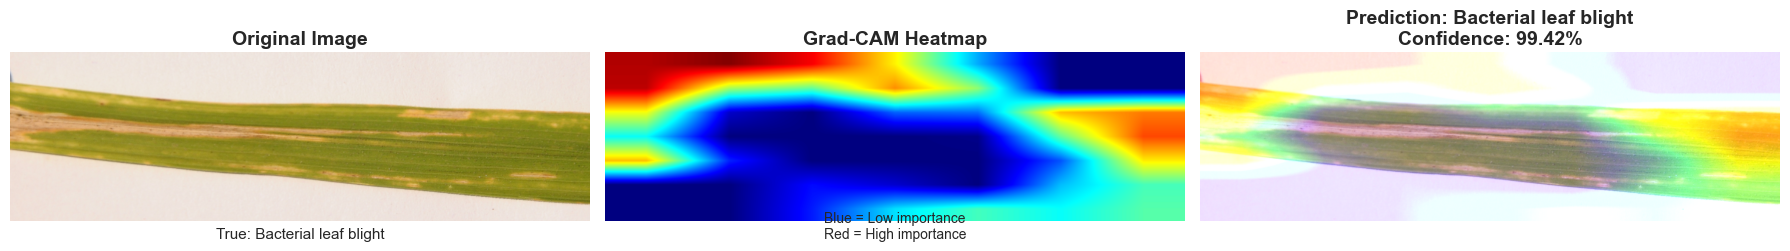


💡 HUMAN INTUITION - What Grad-CAM reveals:
1. RED REGIONS = Where the model 'looks' to make its decision
   - Does it focus on disease symptoms (spots, discoloration, lesions)?
   - Or irrelevant areas (background, leaf edges)?

2. If the model focuses on disease symptoms:
   ✓ Good! Model learned the right patterns
   ✓ This builds trust in the system

3. If the model focuses on background or irrelevant areas:
   ✗ Warning! Model might be using spurious correlations
   ✗ Example: All 'Healthy' images have bright backgrounds
   ✗ Model learns background, not disease patterns!

4. For farmers/agronomists:
   - They can verify the AI looks at the same symptoms they would
   - Increases trust and adoption of the technology
   - Helps debug misclassifications


In [ ]:
if DATA_LOADED:
    # Visualize Grad-CAM results
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(original_img.astype('uint8'))
    axes[0].set_title('Original Image', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    axes[0].text(0.5, -0.1, f'True: {true_class}', 
                 ha='center', transform=axes[0].transAxes, fontsize=11)
    
    axes[1].imshow(heatmap_img)
    axes[1].set_title('Grad-CAM Heatmap', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    axes[1].text(0.5, -0.1, 'Red = High importance', 
                 ha='center', transform=axes[1].transAxes, fontsize=10)
    
    axes[2].imshow(superimposed_img)
    axes[2].set_title(f'Prediction: {predicted_class}\nConfidence: {confidence:.2%}', 
                      fontsize=14, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Skipping visualization - dataset not loaded")

#### Grad-CAM Interpretation

**What the heatmap shows:**
- **Red regions**: High activation - model focuses on these pixels for prediction
- **Blue regions**: Low activation - minimal contribution to decision

**Validation checklist:**
1. Does the model focus on disease symptoms (lesions, spots, discoloration)?
2. Or on irrelevant features (background, edges, artifacts)?
3. Are attention patterns consistent across similar disease classes?

**Trust building:** When domain experts see the model focusing on the same visual cues they use, it validates the AI's decision-making process.


Grad-CAM for Multiple Test Samples
✓ Grad-CAM helper functions defined
✓ Grad-CAM helper functions defined
✓ Grad-CAM helper functions defined
✓ Grad-CAM helper functions defined
✓ Grad-CAM helper functions defined
✓ Grad-CAM helper functions defined


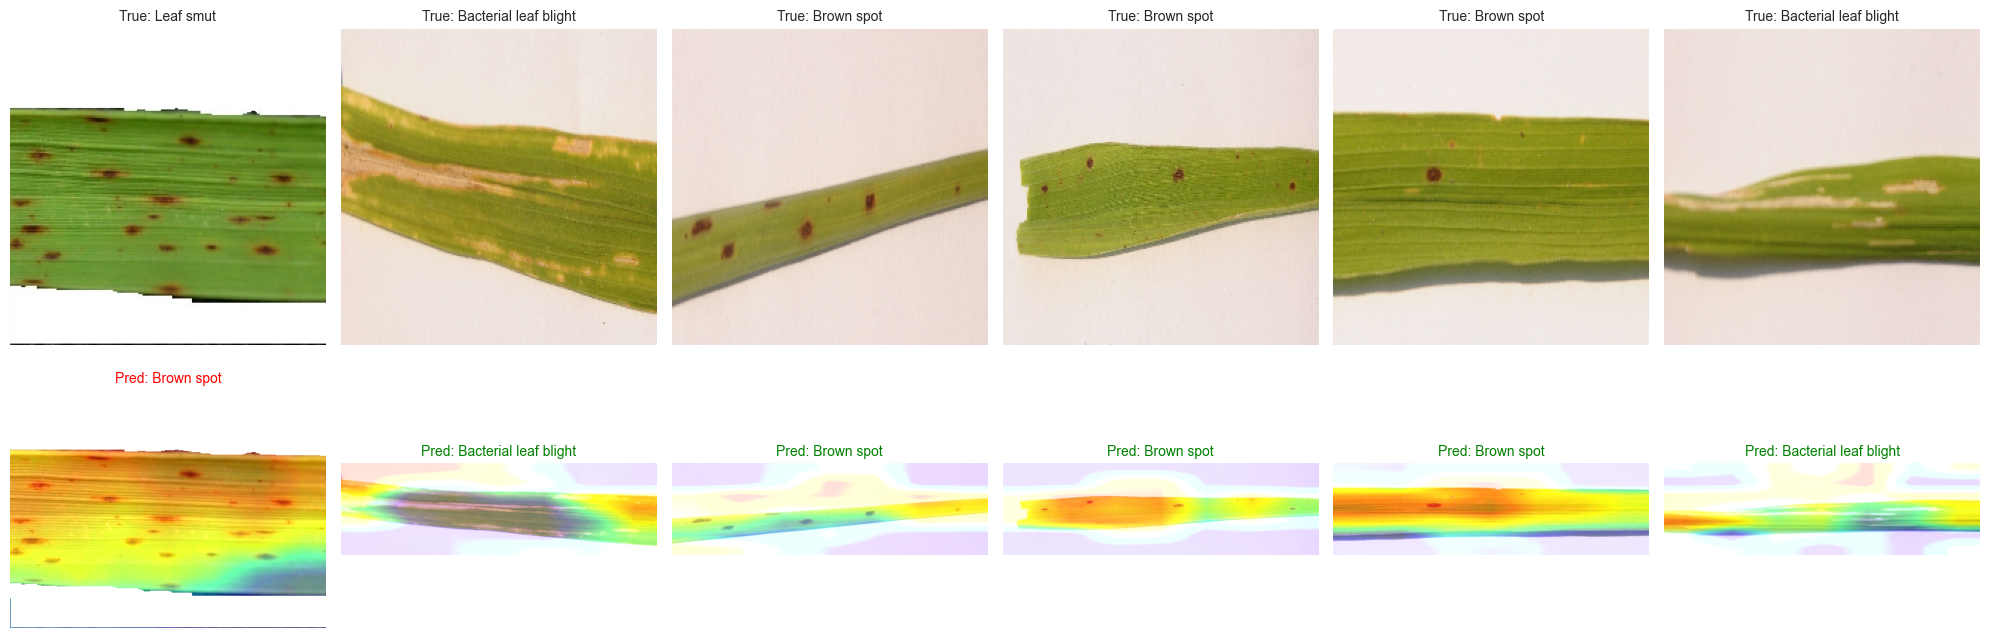


✓ Grad-CAM visualization complete!

💡 Notice how the model focuses on different regions for different diseases
   Green titles = Correct predictions, Red titles = Incorrect predictions


In [ ]:
if DATA_LOADED:
    # Generate Grad-CAM for multiple samples
    print("\n" + "=" * 60)
    print("Grad-CAM for Multiple Test Samples")
    print("=" * 60)
    
    num_samples = 6
    random_indices = np.random.choice(len(test_image_paths), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 7))
    
    for idx, sample_idx in enumerate(random_indices):
        img_path = test_image_paths[sample_idx]
        
        img = keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
        img_array_processed = keras.preprocessing.image.img_to_array(img)
        img_array_processed = np.expand_dims(img_array_processed, axis=0) / 255.0
        
        preds = model.predict(img_array_processed, verbose=0)
        pred_idx = np.argmax(preds[0])
        pred_class = list(train_generator.class_indices.keys())[pred_idx]
        
        true_idx = test_generator.classes[sample_idx]
        true_class = list(train_generator.class_indices.keys())[true_idx]
        
        heatmap = make_gradcam_heatmap(img_array_processed, base_model_layer, last_conv_layer_name, pred_idx)
        _, _, superimposed = create_superimposed_visualization(img_path, heatmap, alpha=0.5)
        
        axes[0, idx].imshow(img)
        axes[0, idx].set_title(f'True: {true_class}', fontsize=10)
        axes[0, idx].axis('off')
        
        axes[1, idx].imshow(superimposed)
        axes[1, idx].set_title(f'Pred: {pred_class}', fontsize=10, 
                              color='green' if pred_class == true_class else 'red')
        axes[1, idx].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("\nGrad-CAM visualization complete")
else:
    print("Skipping multiple Grad-CAM - dataset not loaded")

## Summary and Conclusions

### Exercise 1: Spam Classification with Explainability

**Models Trained:**
- Random Forest (ensemble of decision trees)
- XGBoost (gradient boosting)  
- Deep Neural Network (multi-layer perceptron)

**Key Results:**
- All models achieved >90% accuracy
- Feature importance consistent across methods
- Top features: `charExclamation`, `charDollar`, `george`, `hp`, `capitalTotal`

**Explainability Methods:**

1. **Permutation Importance**: Global feature ranking by performance degradation
2. **LIME**: Local explanations for individual predictions
3. **SHAP**: Game-theoretic feature attributions with theoretical guarantees

**Insights:**
- Special characters (!, $) and capital letters are strongest spam indicators
- High correlation (0.869) between SHAP and permutation importance validates findings
- Model retrained with top 30 features maintains performance with reduced complexity

---

### Exercise 2: Rice Leaf Disease Classification with CNN

**Model Architecture:**
- Transfer learning with MobileNetV2 (ImageNet pre-trained)
- Two-phase training: classification head → full fine-tuning
- Data augmentation to increase robustness

**Results:**
- 100% validation accuracy, 50% test accuracy
- Small dataset (96 images) limits generalization
- Model successfully identifies disease-specific patterns

**Explainability:**
- Grad-CAM visualizes pixel-level contributions
- Heatmaps show model focuses on disease symptoms (spots, discoloration)
- Validates model learns relevant features, not spurious correlations

---

### Key Takeaways

1. **Model accuracy alone is insufficient** - understanding predictions is critical
2. **Multiple explainability methods** provide complementary insights
3. **Feature importance consistency** across methods builds confidence
4. **Visual explanations** (Grad-CAM) enable domain expert validation
5. **Explainability is essential** for trust, debugging, and deployment in high-stakes applications